# OCR

* recognize 5-digit handwritten numbers

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from functools import partial, lru_cache

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops


dh = Path(os.environ['HOME'])
dh = dh/'.torch/data'

## dataset

In [3]:
%%writefile generate_5_digit_dataset.py
from pathlib import Path
from PIL import Image, ImageChops

import numpy as np
from functools import partial, lru_cache

import torch
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from torch.utils.data import Dataset


class Generate5DigitDataset(Dataset):
    
    def __init__(self, data_home: Path, set_size=20000, transform=None):
        self.dh = data_home
        self.set_size = set_size
        self.transform = transform
        
        self.mnist = MNIST(self.dh, transform=self._mnist_transform, download=True)
        self.digit_n = np.array([1, 2, 3, 4, 5])
        self.digit_p = np.array([5, 20, 30, 30, 15])  # n digit prob.
        self.digit_p = self.digit_p / self.digit_p.sum()
        self.np_shape = (28, 150)
        self.wh = (150, 28)  # PIL shape Width x Height

    
    def _resize(self, image):
        base = Image.new('L', self.wh)
        base.paste(image)
        return base
    
    def _mnist_transform(self, image):
        transform = transforms.Compose([
            partial(lambda padding, img: transforms.functional.pad(img, padding), 4),
            transforms.RandomRotation(10),
            transforms.RandomAffine(10),
            transforms.RandomResizedCrop((28, 28), scale=(0.6, 1.0), ratio=(0.75, 1.3)),
            self._resize,
        ])
        return transform(image)
    
    def __len__(self):
        return self.set_size
    
    @lru_cache(maxsize=None)
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError
            
        n_digit = np.random.choice(self.digit_n, 1, p=self.digit_p)
        offsets = np.concatenate([
            np.random.choice(30, 1),
            np.random.choice(np.arange(16, 29), n_digit - 1)
        ])
        offsets = np.add.accumulate(offsets)
        
        image = np.zeros(self.np_shape, dtype=np.int64)
        label = []
        for i in range(n_digit.item()):
            img, lbl = self.mnist[np.random.choice(len(self.mnist), 1).item()]
            img = ImageChops.offset(img, xoffset=offsets[i], yoffset=0)
            img = np.array(img, dtype=np.int64)
            image = image + img
            label.append(lbl)
        image = Image.fromarray(np.clip(image, 0, 255).astype(np.uint8))
        label_len = len(label)

        if self.transform:
            image = self.transform(image)
            label = np.array(label, dtype=np.long) + 1  # 0 reserved for blank
            label = np.concatenate([
                label,
                np.array([0] * (5 - label_len), dtype=np.long)
            ], axis=-1)
            label = torch.from_numpy(label)
            
        return image, (label, label_len)

Writing generate_5_digit_dataset.py


## MNIST recap

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from functools import partial, lru_cache

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops


dh = Path(os.environ['HOME'])
dh = dh/'.torch/data'

In [2]:
batch_size = 128

transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(10),
    transforms.ToTensor(),
])

data_loaders = {
    x: DataLoader(
        MNIST(dh, train=True if x == 'train' else False, transform=transform),
        batch_size=128,
        shuffle=True if x == 'train' else False,
        num_workers=4
    ) for x in ['train', 'val']
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
images, labels = next(iter(data_loaders['train']))
images.shape

torch.Size([128, 1, 28, 28])

In [4]:
labels.shape

torch.Size([128])

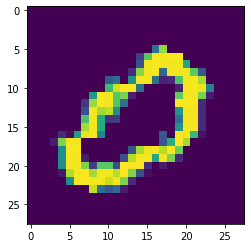

In [16]:
plt.imshow(images[0, 0])

In [17]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),  # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(576, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

In [8]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import FastaiLRFinder, ProgressBar

In [18]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [19]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {'batch loss': x})

lr_finder = FastaiLRFinder()
to_save = {'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.5) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(data_loaders['train'])

0.023818982263780715


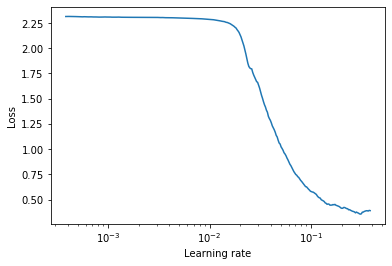

In [21]:
print(lr_finder.lr_suggestion())
lr_finder.plot()

In [22]:
evaluator = create_supervised_evaluator(
    model, metrics={'acc': Accuracy(), 'loss': Loss(nn.CrossEntropyLoss())}, device=device)

optimizer.param_groups[0]['lr'] = lr_finder.lr_suggestion()
trainer.run(data_loaders['train'], max_epochs=10)
evaluator.run(data_loaders['val'])
print(evaluator.state.metrics)


{'acc': 0.9884, 'loss': 0.03487662489414215}


# OCR

## dataloader

In [4]:
import os
from pathlib import Path
from generate_5_digit_dataset import Generate5DigitDataset

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [5]:
dh = Path(os.environ['HOME'])
dh = dh/'.torch/data'

batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),
])

data_loaders = {
    x: DataLoader(
        Generate5DigitDataset(dh, set_size=80000 if x == 'train' else 20000, transform=transform),
        batch_size=batch_size,
        shuffle=True if x == 'train' else False,
        num_workers=8
    ) for x in ['train', 'val']
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### check dataloader

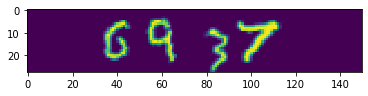

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

images, (labels, label_lens) = next(iter(data_loaders['train']))
plt.imshow(images[0, 0])

In [4]:
labels[0] - 1, label_lens[0]

(tensor([ 4,  1, -1, -1, -1]), tensor(2))

## Model

In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from itertools import groupby


class CRNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3),  # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64, 5, 36
            nn.Conv2d(64, 256, 5),
            nn.ReLU(),  # 256, 1, 32
        )
        self.rnn0 = nn.LSTM(256, 128, 1, bidirectional=True)
        self.rnn1 = nn.LSTM(256, 32, 1, bidirectional=True)
        self.linear = nn.Linear(64, 11)
        
    def forward(self, x):
        N, _, H, W = x.shape
        x = self.cnn(x)  # N, Features, 1, T
        x = x.squeeze()  # N, Features, T
        x = x.permute(2, 0, 1)  # T, N, Features
        x, _ = self.rnn0(x)
        x, _ = self.rnn1(x)
        x = self.linear(x)
        x = F.log_softmax(x, dim=-1)
        return x
    
    def decode(self, x, to_tensor=True):
        def _ndigit(el):
            el = [k for k, g in groupby(el)]
            el = [x for x in el if x != 0]
            el = el[:5]  # clip
            el_len = len(el)            
            el = el + [0] * (5 - el_len)
            return el, el_len

        y = x.transpose(1, 0).detach().cpu().numpy()  # N, T, Features
        y = np.argmax(y, axis=-1)
        y = list(list(el) for el in y)
        y = map(_ndigit, y)
        y, y_len = zip(*y)
        if to_tensor:
            y = torch.tensor(y, dtype=torch.long)
            y_len = torch.tensor(y_len, dtype=torch.long)
            y.to(device), y_len.to(device)
        return y, y_len

## Train

In [7]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import FastaiLRFinder, ProgressBar

In [8]:
from functools import partial

model = CRNN()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)
ctc_loss = nn.CTCLoss()

def criterion(ctc_loss, x, y):
    T, N, _ = x.shape
    y, y_lens = y
    x_lens = torch.full(size=(N,), fill_value=T, dtype=torch.long)
    loss = ctc_loss(x, y, x_lens, y_lens)
    return loss

criterion = partial(criterion, ctc_loss)

In [9]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {'batch loss': x})

lr_finder = FastaiLRFinder()
to_save = {'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.5) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(data_loaders['train'])

0.001098183303195036


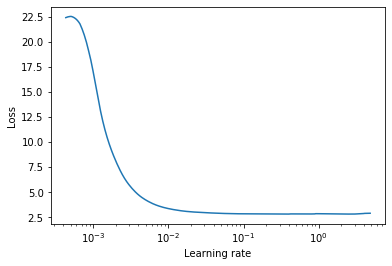

In [10]:
print(lr_finder.lr_suggestion())
lr_finder.plot()

In [11]:
from ignite.engine import Events

def output_transform_acc(output):
    y_pred, (y, _) = output
    y_pred, _ = model.decode(y_pred)
    wt = torch.tensor([10000, 1000, 100, 10, 1], dtype=torch.long).to(device)
    y_pred, y = (y_pred * wt).sum(axis=-1), (y * wt).sum(axis=-1)
    y_pred = (y_pred == y).long()
    return y_pred, torch.ones_like(y_pred)
    

evaluator = create_supervised_evaluator(
    model,
    metrics={
        'acc': Accuracy(
            output_transform=output_transform_acc
        ),
        'loss': Loss(criterion)},
    device=device)


history = {
    'train': {'acc': [], 'loss': []},
    'val': {'acc': [], 'loss': []},}

def log_results(engine, data_loaders, history, mode):
    evaluator.run(data_loaders[mode])
    metrics = evaluator.state.metrics
    acc = metrics['acc']
    loss = metrics['loss']
    history[mode]['acc'].append(acc)
    history[mode]['loss'].append(loss)
    print(f'{mode:5} - Epoch: {engine.state.epoch}'
          f' Acc: {acc:.2f} Loss {loss:.2f}')

trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), log_results, data_loaders, history, 'train')
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), log_results, data_loaders, history, 'val')

optimizer.param_groups[0]['lr'] = lr_finder.lr_suggestion()
trainer.run(data_loaders['train'], max_epochs=100)


train - Epoch: 5 Acc: 0.00 Loss 2.78
val   - Epoch: 5 Acc: 0.00 Loss 2.78



train - Epoch: 10 Acc: 0.00 Loss 2.66
val   - Epoch: 10 Acc: 0.00 Loss 2.66



train - Epoch: 15 Acc: 0.00 Loss 2.21
val   - Epoch: 15 Acc: 0.00 Loss 2.19



train - Epoch: 20 Acc: 0.42 Loss 0.91
val   - Epoch: 20 Acc: 0.43 Loss 0.89



train - Epoch: 25 Acc: 0.69 Loss 0.42
val   - Epoch: 25 Acc: 0.70 Loss 0.41



train - Epoch: 30 Acc: 0.75 Loss 0.31
val   - Epoch: 30 Acc: 0.76 Loss 0.30



train - Epoch: 35 Acc: 0.80 Loss 0.24
val   - Epoch: 35 Acc: 0.81 Loss 0.23



train - Epoch: 40 Acc: 0.83 Loss 0.20
val   - Epoch: 40 Acc: 0.83 Loss 0.20



train - Epoch: 45 Acc: 0.85 Loss 0.18
val   - Epoch: 45 Acc: 0.85 Loss 0.17



train - Epoch: 50 Acc: 0.86 Loss 0.16
val   - Epoch: 50 Acc: 0.87 Loss 0.15



train - Epoch: 55 Acc: 0.87 Loss 0.14
val   - Epoch: 55 Acc: 0.88 Loss 0.13



train - Epoch: 60 Acc: 0.88 Loss 0.13
val   - Epoch: 60 Acc: 0.89 Loss 0.12



train - Epoch: 65 Acc: 0.88 Loss 0.13
val   - Epoch: 65 Acc: 0.89 Loss 0.12



train - Epoch: 70 Acc: 0.90 Loss 0.11
val   - Epoch: 70 Acc: 0.90 Loss 0.11



train - Epoch: 75 Acc: 0.91 Loss 0.10
val   - Epoch: 75 Acc: 0.91 Loss 0.10



train - Epoch: 80 Acc: 0.90 Loss 0.10
val   - Epoch: 80 Acc: 0.91 Loss 0.10



train - Epoch: 85 Acc: 0.91 Loss 0.09
val   - Epoch: 85 Acc: 0.92 Loss 0.09



train - Epoch: 90 Acc: 0.92 Loss 0.09
val   - Epoch: 90 Acc: 0.92 Loss 0.09



train - Epoch: 95 Acc: 0.92 Loss 0.08
val   - Epoch: 95 Acc: 0.92 Loss 0.08



train - Epoch: 100 Acc: 0.92 Loss 0.08
val   - Epoch: 100 Acc: 0.93 Loss 0.08


State:
	iteration: 31300
	epoch: 100
	epoch_length: 313
	max_epochs: 100
	output: 0.11255040764808655
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [12]:
mh = Path('data/models')

torch.save(model.state_dict(), mh/'ocr-ctc-crnn-5digit-checkpoint-1.ptc')

In [14]:
len(history['train']['acc'])

20

Text(0.5, 1.0, 'Acc')

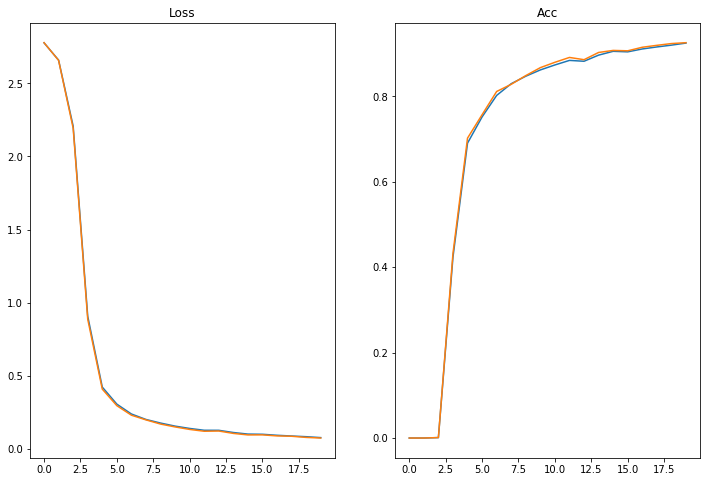

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].plot(range(20), history['train']['loss'], label='train')
axs[0].plot(range(20), history['val']['loss'], label='train')
axs[0].set_title('Loss')


axs[1].plot(range(20), history['train']['acc'], label='train')
axs[1].plot(range(20), history['val']['acc'], label='train')
axs[1].set_title('Acc')

In [8]:
mh = Path('data/models')

model = CRNN()
model.load_state_dict(torch.load(mh/'ocr-ctc-crnn-5digit-checkpoint-1.ptc'))

<All keys matched successfully>

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

images, (labels, label_lens) = next(iter(data_loaders['val']))

tensor([ 7,  8,  4,  3, -1])


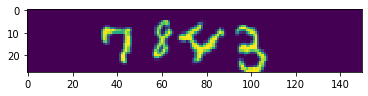

In [10]:
index = 120
plt.imshow(images[index, 0])
y_pred = model(images)
y_pred, _ = model.decode(y_pred)
print(y_pred[index] - 1)